# INFERENCE PROCEDURE WITH SYNTHETIC DATA

We present here the numerical implementation of the inference procedure of bacterial swimming parameters given a host biofilm, presented in S. Labarthe and al. All notations are presented in the article. We remind the reader how two deterministic terms have been incorporated with a stochastic noise in the governing equation.

## Swimming equation 

We aim to solve the following stochastic Ordinary Differential equation (ODE): 

We consider bacterial swimmers as Lagrangian particles and we model the different forces involved in the update of their velocity $\mathbf{v}$. We assume that the swimmer motion can be modelled by a stochastic process with a deterministic drift:
\begin{equation}
\mathrm{d} \mathbf{v} = \underbrace{\gamma (\alpha(b) - \|\mathbf{v}\|) \frac{\mathbf{v}}{\|\mathbf{v}\|}\mathrm{dt}}_{\text{speed selection}} +\underbrace{ \beta \frac{\nabla b}{\| \nabla b \|} \mathrm{dt}}_{\text{direction selection}} + \underbrace{\mathbf{\eta} \mathrm{dt}}_{\text{random term}}
\label{eq:state-equation}
\end{equation}
where the right hand side is composed of two deterministic terms in addition to a gaussian noise, each weighted by the parameters $\gamma$, $\beta$ and $\epsilon$.

The first term shapes the velocity magnitude of the swimmer according to the local biofilm density. This term can be interpreted as a penalization term that pulls the instantaneous speed of the swimmer towards a penalization velocity $\alpha(b)$, i.e. a prescribed target velocity that depends on the host biofilm density $b$. The weight $\gamma$ can be interpreted as a penalization coefficient, proportionally inverse to a relaxation time $\tau$, $\gamma \sim \frac{1}{\tau}$.
We model the target speed $\alpha(b)$ as a linear function of $v_0$ and $v_1$, the swimmer characteristic speed in the highest and lowest density regions respectively:
\begin{equation*}
\alpha(b) = v_0 (1-b) + b v_1 = v_0 + b (v_1-v_0)
\end{equation*}

The second term updates the velocity direction according to the local gradient of the biofilm density $\nabla b$. The sign of $\beta$ indicates if the swimmer is inclined to go up (negative $\beta$) or down (positive $\beta$) the host biofilm gradient, while the weight magnitude indicate the influence of this mechanism in the swimmer kinematics.

The third term is a stochastic diffusive process that models the dispersion around the deterministic drift modelled by the two first terms. We define
 \[ \mathbf{\eta} \sim \mathcal{N}(0,\epsilon) \]
The term $\mathbf{\eta}$ can also be interpreted as a model of the modelling errors, tuned by the term $\epsilon$.

We can define characteristic speed and acceleration $V^*$ and $A^*$ in order to set a non-dimension version of Eq. \eqref{eq:state-equation}
\begin{equation}
\mathrm{d} \mathbf{v} = \gamma^\prime (v_0^\prime + b (v_1^\prime-v_0^\prime) - \|\mathbf{v}\|) \frac{\mathbf{v}}{\|\mathbf{v}\|}\mathrm{dt} + \beta^\prime \frac{\nabla b}{\| \nabla b \|} \mathrm{dt} + \mathbf{\eta^\prime} \mathrm{dt}
\label{eq:non-dimension-state-equation}
\end{equation}
where $\gamma^\prime = \frac{\gamma V^*}{A^*}$, $v_0^\prime = \frac{v_0}{V^*}$, $v_1^\prime = \frac{v_1}{V^*}$, $\beta^\prime = \frac{\beta}{A^*}$, $\eta^\prime \sim \mathcal{N}(0,\epsilon^\prime)$ and $\epsilon^\prime = \frac{\epsilon}{A^{*2}}$.


This non-dimension version will strongly improve the inference process and will allow an analysis of the relative contribution of the different terms in the kinematics.

## Inference implementation

Equation \eqref{eq:non-dimension-state-equation} is re-written as a state equation on the acceleration for the bacterial strain $s$ and the swimmer $i$

\begin{align}
A^s_i(t) &= \gamma (v_0^s + b(t,X^s_i(t)) (v_1^s-v_0^s) - \|V^s_i(t)\|) \frac{V^s_i(t)}{\|V^s_i(t)\|} + \beta^s \frac{\nabla b(t,X^s_i(t))}{\| \nabla b(t,X^s_i(t)) \|} + \mathbf{\eta^s} \\ &:= f_A\left( \theta^s,b(t),V^s_i(t), X^s_i(t)\right) + \mathbf{\eta^s}
\label{eq:state-equation-acceleration}
\end{align}
where 
\[ \theta^s:=(\gamma^s,v_0^s,v_1^s,\beta^s) \]
are species-dependant equation parameters %, $b(t,X)$ is the time-serie of 2D maps of host biofilm obtained by imaging and $X^s_i(t)$, $V^s_i(t)$ and $A^s_i(t)$ are respectively the position, speed and acceleration of the individual $i$ of the species $s$ at time $t$ obtained by post-processing the swimmer channel of the images. 
The function $f_A$ can be seen as the deterministic drift of the random walk, gathering all the deterministic mechanisms included in the model.

Inferring the parameters $\theta^s$ can then be stated in a Bayesian framework as solving the non linear regression problem

\begin{equation}
 A^s_i(t) \sim \mathcal{N}\left(f_A\left(\theta^s|b(t),V^s_i(t), X^s_i(t)\right),\epsilon^s\right)
 \label{eq:likelihood}
\end{equation}
from the data $b(t,X)$, $X^s_i(t)$, $V^s_i(t)$ and $A^s_i(t)$, with prior distributions
\begin{align}
\theta^s &\sim \mathcal{N}(0,1) \\
\epsilon^s &\sim \mathcal{N}(0,1).
\label{eq:priors}
\end{align}
and additional constrains on the parameters
\[\gamma^s\geq 0, \quad v_0^s \geq 0, \quad v_1^s \geq 0, \quad \epsilon^s \geq 0 \]
We note that Equation \eqref{eq:likelihood} can be seen as a likelihood equation of the parameter $\theta^s$ knowing $A^s_i(t),b(t),V^s_i(t)$ and $X^s_i(t)$. The parameter $\epsilon^s$ can now be seen as a corrector of both modelling errors in the deterministic drift and observation errors between the observed and the true instantaneous acceleration. Alternative settings where these uncertainties sources are separated and a true state for position and acceleration is inferred can be defined (see Annex \ref{sec:inference-models}). The inference problem is implemented in the Bayesian HMC solver [Stan](https://mc-stan.org/) using its python interface [PyStan](https://mc-stan.org/users/interfaces/pystan).

## Code organisation

User find in this notebook 4 distinctive parts: 
- Compute / Load the swimming data
- Visualize the data descriptors
- Compute / Load the inference procedure
- Visualize the inference results
- Run an experiment-driven simulation 
- Visualize the simulation results

Let's upload the modules:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")
import ternary
## Swimmer library
from pre_process2D import *
from post_process2D import *
from inference_stan import *
from RandomWalk2D import *

In [2]:
np.random.seed(987654321)

This is the beginning.
First, let's write down the input data:

In [3]:
BIOFILM=True
if BIOFILM:
    m = 426                   #image resolution. x direction (pixels)
    n = 426                   #image resolution. y direction (pixels)
    xInit = 0.0               #x origin coordinate in microscope referential. micro-meters (0.0 if synthetic data)
    yInit = 0.0               #y origin coordinate in microscope referential. micro-meters (0.0 if synthetic data)
    Lx = 147.62                 #domain length. x direction. micro-meters
    Ly = 147.62                 #domain length. y direction. micro-meters 
else:
    m = 256                   #image resolution. x direction (pixels)
    n = 256                   #image resolution. y direction (pixels)
    xInit = 0.0               #x origin coordinate in microscope referential. micro-meters (0.0 if synthetic data)
    yInit = 0.0               #y origin coordinate in microscope referential. micro-meters (0.0 if synthetic data)
    Lx = 88.9                 #domain length. x direction. micro-meters
    Ly = 88.9                 #domain length. y direction. micro-meters 
Tf = 30                   #simulation duration
dt = 0.134                #simulation time step
#Input = 'input2/Mock_biofilm/'         #folder for input data (mock biofilm map)
Input = 'input2/biofilm/'         #folder for input data (B.pumilus host biofilm map)
Synthetic_data_folder='Synthetic_data' # folder for synthetic data output
swimmer_nb = 50           #swimmer number

A few more parameters:

In [4]:
hx = Lx/m                 #space step. x direction. micro-meters
hy = Ly/n                 #space step. y direction. micro-meters
Ncycle = int(Tf/dt)       #number of time steps
steps = (dt, hx, hy)      #steps
origin = [xInit,yInit]    #Origin coordinates

Param={
    'm':m,'n':n,'Ncycle':Ncycle,'xInit':xInit,'yInit':yInit,'Lx':Lx,'Ly':Ly,
    'Tf':Tf,'dt':dt,'Input':Input,'swimmer_nb':swimmer_nb,'hx':hx,'hy':hy,
    'steps':steps,'origin':origin
    }
print(Ncycle)

223


# Step 0: Compute synthetic ground truth data

This step can be done once. At the end of this step, the synthetic data will be stored: ones will be able to load them when needed.

Customed swimmer parameters are defined.

In [5]:
swimmer_beta = 10              #Beta parameter (direction selection)
swimmer_gamma = 10             #Gamma parameter (speed relaxation constant)
swimmer_eps = 40               #Epsilon parameter (stochastic term)
swimmer_v0_in_biofilm = 5      #V0 parameter (target speed in the biofilm)
swimmer_v1_in_matrix = 1       #V1 parameter (target speed in the EPS)

#----Adding equation parameter to the Param dictionnary----#
eq_param={"swimmer_beta":swimmer_beta, "swimmer_gamma":swimmer_gamma,"swimmer_eps":swimmer_eps,
          "swimmer_v0_in_biofilm":swimmer_v0_in_biofilm,"swimmer_v1_in_matrix":swimmer_v1_in_matrix}
for key,val in eq_param.items():
    Param[key]=val

Adimensioning values are defined. $V_{ref}$ and $A_{ref}$ are observed mean velocity and acceleration on real dataset

In [6]:
Vref = 7.47#7.248109476023929   #speed characteristic value
Aref = 68.29#71.18318024390867   #Acceleration characteristic value
Xref = Vref*Vref/Aref      #postiion characteristic value
Vrefg = Vref
Arefg = Aref
Xrefg = Xref
print("Dimensioned parameters")
print("Param vel : v0=",Param['swimmer_v0_in_biofilm'],
      " v1=",Param['swimmer_v1_in_matrix'],
      " gamma=",Param['swimmer_gamma'],
      " beta=",Param['swimmer_beta'],
      " eps=",Param['swimmer_eps'])

#----Adding characteristic values to the Param dictionnary----#
ref_val={"Vref":Vref,'Aref':Aref,'Xref':Xref,'Vrefg':Vrefg,'Arefg':Arefg,'Xrefg':Xrefg}
for key,val in ref_val.items():
    Param[key]=val

Dimensioned parameters
Param vel : v0= 5  v1= 1  gamma= 10  beta= 10  eps= 40


In [7]:
Dimensioned = True
if not Dimensioned:
    print("Adimensioned parameters")
    print("Param vel : v0=",Param['swimmer_v0_in_biofilm']/Param['Vref'],
          " v1=",Param['swimmer_v1_in_matrix']/Param['Vref'],
          " gamma=",Param['swimmer_gamma']*Param['Vref']/Param['Aref'],
          " beta=",Param['swimmer_beta']/Param['Aref'],
          " eps=",Param['swimmer_eps']/Param['Aref'])
else:
    print("For the sake of comparison, this is the adimensioned parameters")
    print("Param vel : v0=",Param['swimmer_v0_in_biofilm']/Param['Vref'],
          " v1=",Param['swimmer_v1_in_matrix']/Param['Vref'],
          " gamma=",Param['swimmer_gamma']*Param['Vref']/Param['Aref'],
          " beta=",Param['swimmer_beta']/Param['Aref'],
          " eps=",Param['swimmer_eps']/Param['Aref'])

For the sake of comparison, this is the adimensioned parameters
Param vel : v0= 0.6693440428380187  v1= 0.13386880856760375  gamma= 1.0938644018157855  beta= 0.14643432420559377  eps= 0.5857372968223751


### Initialisation of the swimmers

In [8]:
Data_files={ #files containing the images and the gradient map
            'biofilm_gray_scale':Input+'2D_grayscale.'+str(0)+'.hdf5', #biofilm density in gray scale
            'biofilm_grad_bact_x':Input+'2D_gradbactX.'+str(0)+'.hdf5',#biofilm gradient - x direction
            'biofilm_grad_bact_y':Input+'2D_gradbactY.'+str(0)+'.hdf5' #biofilm gradient - y direction
           }
#----Import of images------------------------------#
bact,gradb_x,gradb_y,is_in_plate = get_Biofilm_Image(Param,Data_files)

#----Trajectory initialization for the swimmers----#
swimmer_list_loc = Trajectory_Init(Param,bact,gradb_x,gradb_y,is_in_plate,Dimensioned=Dimensioned)

### Time evolution

In [9]:
#-----------------------------------------Loops over time begins----------------------------#
print("len swimmer_list_loc BEFORE: ",len(swimmer_list_loc))
for t in range(Ncycle):                                                                            #Time loop
    #----Trajectories incrementation----#
    for swimmer in swimmer_list_loc:                                                               #Loop on swimmers
        if Dimensioned:
            swimmer.trajectory.solveNext(t,origin,bact[t+1,:,:],gradb_x[t+1,:,:],gradb_y[t+1,:,:]) #next position
        else:
            swimmer.trajectory.solveNextNondim(t,origin,bact[t+1,:,:],gradb_x[t+1,:,:],gradb_y[t+1,:,:],Param['Xref'],Param['Vref']) #next position
        swimmer.trajectory.GetBiofilmColorCode(is_in_plate[t+1,:,:])                               #Check if the swimmer is inside the domain
        swimmer.trajectory.GetBiofilm(bact[t+1,:,:],gradb_x[t+1,:,:],gradb_y[t+1,:,:])             #Get local biofilm value
    swimmer_list=swimmer_list_loc
print('len swimmer_list_loc AFTER: ',len(swimmer_list_loc))

#----Update swimmer_ID----#
curr_ID = 0
for swimmer in swimmer_list:
    maxID = np.max(swimmer.trajectory.swimmer_ID)
    swimmer.trajectory.swimmer_ID += curr_ID
    curr_ID += maxID+1
    

    

len swimmer_list_loc BEFORE:  50
len swimmer_list_loc AFTER:  50


-------------------------------------------
--------    Data Processing    ------------


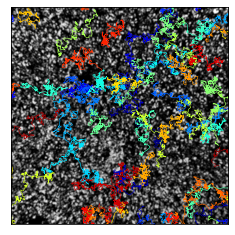

In [10]:
print("-------------------------------------------")
print("--------    Data Processing    ------------")
#----Data processing----#
data = DataProcessing(swimmer_list)

### Extract and reformate data as needed for Stan inference

In [11]:
#----Extract the data (biofilm density and gradients) at swimmer position ----#
#----and organize them in dedicated data structure----#
YVx,YVy,YB,YgradBx,YgradBy,YAx,YAy,Yx,Yy,YindexTime,YindexFirst,YindexFirstV,YindexFirstA,truePositionsNb = get_data(Param,data,bact,gradb_x,gradb_y)


print("Number of active parameters (particules x time):",truePositionsNb,"/",Param['Nt'],np.shape(YAx))
if Dimensioned:
    print("Rescaling varaibles: V* = ",data.Vmean," A* = ",data.Amean," X* = ",data.Vmean*data.Vmean/data.Amean," D = ",data.dist)
else:
    print("Rescaling varaibles: V* = ",data.Vmean*Xref/Vref," A* = ",data.Amean*Xref/Vref*Xref/Vref," X* = ",data.Vmean*data.Vmean/data.Amean," D = ",data.dist)
print("GLOBAL STD: ",np.std([YAx/data.Amean, YAy/data.Amean]),np.std(YAx/data.Amean),np.std(YAy/data.Amean))

#----Save the data for inference----#
Path(Synthetic_data_folder).mkdir(exist_ok=True)
write_data(Synthetic_data_folder,YVx,YVy,YB,YgradBx,YgradBy,YAx,YAy,Yx,Yy,YindexTime,YindexFirst,YindexFirstV,YindexFirstA,data)



Number of active parameters (particules x time): 11108 / 16128 (10964,)
Rescaling varaibles: V* =  7.443410562371117  A* =  67.62451366475509  X* =  0.8192940369920007  D =  152.11114192167076
GLOBAL STD:  0.8118107534936497 0.8066722290852818 0.816916814735131


# Step 1: Load the synthetic ground truth data

The synthetic data that were previously computed are loaded.

In [12]:
#----Load the data for inference----#

data_d = read_data(Synthetic_data_folder)
#YVx, YVy, YB, YgradBx, YgradBy, YAx, YAy, Yx, Yy, YindexTime, YindexFirst, YindexFirstV, YindexFirstA, data
Param['Aref'] = data_d['data'].Amean
Param['Vref'] = data_d['data'].Vmean
Param['Xref'] = Param['Vref']*Param['Vref']/Param['Aref']

DATA file:  Synthetic_data/DATA_YVx.dat
DATA file:  Synthetic_data/DATA_YVy.dat
DATA file:  Synthetic_data/DATA_YB.dat
DATA file:  Synthetic_data/DATA_YgradBx.dat
DATA file:  Synthetic_data/DATA_YgradBy.dat
DATA file:  Synthetic_data/DATA_YAx.dat
DATA file:  Synthetic_data/DATA_YAy.dat
DATA file:  Synthetic_data/DATA_Yx.dat
DATA file:  Synthetic_data/DATA_Yy.dat
DATA file:  Synthetic_data/DATA_YindexTime.dat
DATA file:  Synthetic_data/DATA_YindexFirst.dat
DATA file:  Synthetic_data/DATA_YindexFirstV.dat
DATA file:  Synthetic_data/DATA_YindexFirstA.dat
DATA file:  Synthetic_data/DATA_data.dat


The number of observed swimmer positions (where the swimmers are located in the computational domain) corresponds to:

In [13]:
truePositionsNb = data_d['YindexFirst'][-1]-1

And the maximum number is:

In [14]:
Param['Nt'] = (Ncycle+1)*data_d['data'].swimmer_Nb

Let's check the size of the acceleration vectors:

In [15]:
Nta = data_d['YindexFirst'][-1]-1 - 2*data_d['data'].swimmer_Nb
print("SIZE accelerations vectors: ",np.shape(data_d['YAx']),np.shape(data_d['YAy']))
print("expected SIZE: ",Nta)

SIZE accelerations vectors:  (10964,) (10964,)
expected SIZE:  10964


Characteristic values:

In [16]:
print("REFS (X-V-A): ",Xref,Vref,Aref)
Dref = Vref*Vref/Aref
Depref = Dref

REFS (X-V-A):  0.8171167081563918 7.47 68.29


# Step2: Visualize the data descriptors

Let's extract the right number of data.

In [17]:
data_list_a=["YBa","YgradBxa","YgradBya","YVxa","YVya"]
tmp_t = convert(data_d)
for i_a,a in enumerate(data_list_a):
    data_d[a]=tmp_t[i_a]
data_d['Nta'] = data_d['YindexFirst'][-1]-1 - 2*data_d['data'].swimmer_Nb
    

Display the swimmer occupancy (i.e. the total visited area of the swimmer population) 

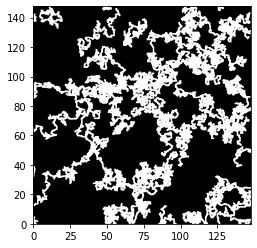

In [18]:
data_d['data'].computeMapOccupancy()

Display the swimmer trajectories

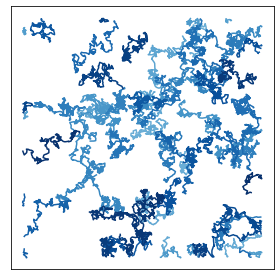

In [19]:
fig, ax = plt.subplots()
Ntot = data_d['data'].swimmer_Nb
plotMap_Obs(0,ax,0,Ntot,data_d['Yx'], data_d['Yy'],
            data_d['data'].swimmer_Nb,
            data_d['YindexFirst'],
            data_d['data'].length_x_inf,
            data_d['data'].length_x_sup,
            data_d['data'].length_y_inf,
            data_d['data'].length_y_sup)
plt.show()

Data are re-assembled for visualization.

In [20]:
data_visu=ReformateDataForVizualisation(Param,data_d,
                                        Aref,Vref,Xref,
                                        Dref,Depref)

*****$||A||$
number of trajectories Ground truth 72
mean Ground truth 0.9902549958230354
percentile Ground truth {1: 0.8041251320982427, 5: 0.8884047570719406, 25: 0.957942166193792, 50: 0.9957967222398538, 75: 1.0228187699416174, 95: 1.0634616464450346, 99: 1.1360162457159249}
wideness Ground truth 0.17505688937309405
*****$||V||$
number of trajectories Ground truth 72
mean Ground truth 0.9964405036641385
percentile Ground truth {1: 0.8740082380658357, 5: 0.9185515062725891, 25: 0.9608880250169018, 50: 0.9948699540245318, 75: 1.0209453883162052, 95: 1.0746045566592586, 99: 1.1888236777109644}
wideness Ground truth 0.1560530503866695
*****dist
number of trajectories Ground truth 72
mean Ground truth 186.15595594033243
percentile Ground truth {1: 11.294624741731344, 5: 15.562410838618174, 25: 70.74585781534337, 50: 253.6912375113033, 75: 272.99094384641614, 95: 281.47566190578044, 99: 286.4625872433141}
wideness Ground truth 265.91325106716226
*****disp
number of trajectories Ground tru

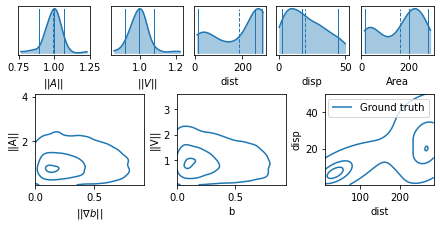

In [21]:
fig =  PlotDescriptors(data_visu)
fig.savefig('TestSecondGraph.pdf')
plt.show()

# Step 3: Compute / Load the inference procedure

Inference procedure:

In [22]:
print("REFS (X-V-A): ",Param['Xref'],Param['Vref'],Param['Aref'])
print("(Normalized) Ground truth parameters : v0=",Param['swimmer_v0_in_biofilm']/Param['Vref']," v1=",Param['swimmer_v1_in_matrix']/Param['Vref']," gamma=",swimmer_gamma*Param['Vref']/Param['Aref']," beta=",swimmer_beta/Param['Aref']," eps=",swimmer_eps/Param['Aref'])

REFS (X-V-A):  0.8192940369920007 7.443410562371117 67.62451366475509
(Normalized) Ground truth parameters : v0= 0.6717350813989277  v1= 0.13434701627978554  gamma= 1.100697093256955  beta= 0.14787537030690476  eps= 0.591501481227619


### Data renormalization and parameter inference

Input data are renormalized. Then, the stan inference is launched : the model is first compiled, then the Bayesian inference is conducted.

The stan model compilation and the fitting lasts several minutes.

In [23]:
#---- Create output folder ----#
Stan_output_folder='InferenceOutputFolder'
Path(Stan_output_folder).mkdir(exist_ok=True)


Inference can be skipped by turning off the INFERENCE variable.

In [24]:
INFERENCE=False
if INFERENCE:
    #---- Data renormalization ----#
    YVx_renormalized = YVx/Param['Vref']
    YVy_renormalized = YVy/Param['Vref']
    YAx_renormalized = YAx/Param['Aref']
    YAy_renormalized = YAy/Param['Aref']

    #---- Bayesian inference. Some warnings pop up during the warmup. This is a normal feature ----#
    fit, df = stanSwimmingA(Param['Xref'], Param['Vref'], Param['Aref'], truePositionsNb, 
                        Param['Nt'], Param['Ncycle']+1, data.swimmer_Nb, 
                        Param['m'], Param['n'], 0, 0, Param['hx'], 
                        Param['hy'], Param['dt'],YVx_renormalized, YVy_renormalized, 
                        YB, YgradBx, YgradBy, YAx_renormalized, YAy_renormalized, 
                        YindexTime, YindexFirstA, YindexFirstV, YindexFirst,
                        output_folder= Stan_output_folder)

In [25]:
dict = read_stan_file(Stan_output_folder+'/STAN_Abis_fit.dat')

STAN file:  InferenceOutputFolder/STAN_Abis_fit.dat


In [26]:
fit = dict['fit']

In [27]:
gamma = fit['gamma']
v0 = fit['v0']
v1 = fit['v1']
beta = fit['beta']
sigma = fit['sigma0'] #'0'

# Step 4: Visualize the inference results

In [28]:
Param['inferred_swimmer_beta'] = np.mean(beta)
Param['inferred_swimmer_gamma'] = np.mean(gamma)
Param['inferred_swimmer_eps'] = np.mean(sigma)
Param['inferred_swimmer_v0_in_biofilm'] = np.mean(v0)
Param['inferred_swimmer_v1_in_matrix'] = np.mean(v1)

print("(Normalized) Ground truth parameters : v0=",Param['swimmer_v0_in_biofilm']/Param['Vref']," v1=",Param['swimmer_v1_in_matrix']/Param['Vref']," gamma=",Param['swimmer_gamma']*Param['Vref']/Param['Aref']," beta=",Param['swimmer_beta']/Param['Aref']," eps=",Param['swimmer_eps']/Param['Aref'])
print("(Normalized) inferred parameters : v0=",Param['inferred_swimmer_v0_in_biofilm']," v1=",Param['inferred_swimmer_v1_in_matrix']," gamma=",Param['inferred_swimmer_gamma']," beta=",Param['inferred_swimmer_beta']," eps=",Param['inferred_swimmer_eps'])

(Normalized) Ground truth parameters : v0= 0.6717350813989277  v1= 0.13434701627978554  gamma= 1.100697093256955  beta= 0.14787537030690476  eps= 0.591501481227619
(Normalized) inferred parameters : v0= 0.6502247466148928  v1= 0.1362124255387418  gamma= 1.0793079860749795  beta= 0.15576151295296864  eps= 0.5935718842601097


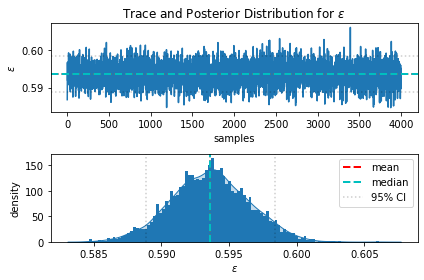

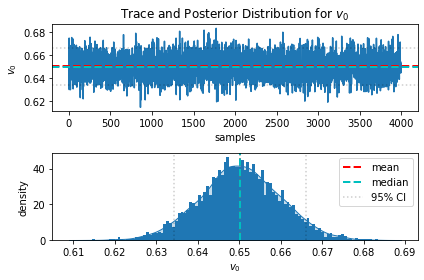

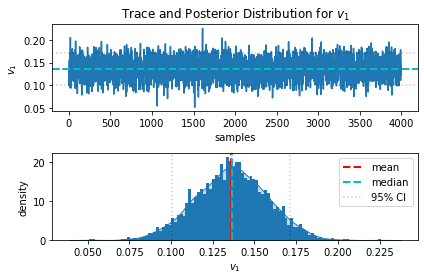

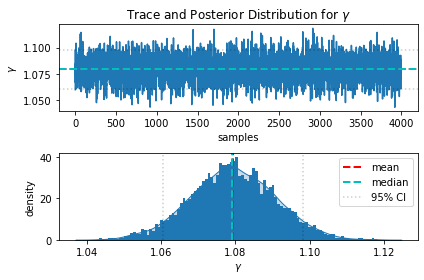

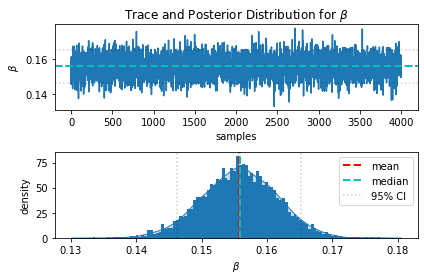

In [29]:
plot_trace(sigma,r'$\epsilon$')
plot_trace(v0,r'$v_0$')
plot_trace(v1,r'$v_1$')
plot_trace(gamma,r'$\gamma$')
plot_trace(beta,r'$\beta$')

**Legend: Inference convergence validation.** The markov chain (upper panel) and the
posterior distribution (lower panel) of each parameter is displayed, showing good convergence of the
stochastic sampling of the posteriors.

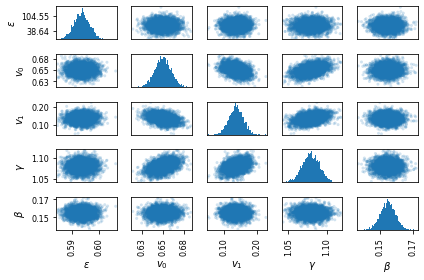

In [30]:
plot_pairs(sigma,v0,v1,gamma,beta)

**Pairplot of parameter markov chains**. No strong covariance effect can be observed, showing that the model can not be reduced by analytical dependence between parameters. Slight correlation is observed between the parameters $v_0$, $v_1$ and $\gamma$: this feature is not surprising since $\gamma$, $v_0$ and $v_1$ are in the same term of the state equation. The correlation is however too low to expect a model reduction.

PLOT TERNARY

<Figure size 432x288 with 0 Axes>

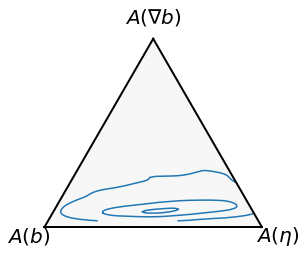

In [31]:
#----- Computation of each equation term contribution in barycentric coordinates -----#
lambda1, lambda2, lambda3 = computeLambdaYAnobatch_v4(Param['Xref'], Param['Vref'], Param['Aref'], 
                                                      YindexFirst[-1]-1, data.swimmer_Nb, 
                                                      dt, YVx/Param['Vref'], YVy/Param['Vref'],
                                                      YB, YgradBx, YgradBy, YAx/Param['Aref'], 
                                                      YAy/Param['Aref'], YindexFirstA, YindexFirstV, 
                                                      YindexFirst, gamma, v0, v1, beta, sigma)

#----- Variables in xy coordinates-----#
x = pd.DataFrame({
        "Species":['Current' for i in range(np.shape(lambda2)[0])],
        "value":[0.5*(2*lambda3[i] + lambda2[i]) for i in range(np.shape(lambda2)[0])]})
y = pd.DataFrame({
        "Species":['Current' for i in range(np.shape(lambda2)[0])],
        "value":[0.5*np.sqrt(3) * lambda2[i] for i in range(np.shape(lambda2)[0])]})

#----- Computation of percentile values-----#
percentile_val_sp, mean_sp, kde_sp, max_val_dist, gx0y0, gx0, gy0 = ComputePercentile2D(x,y)

#----- Contour computation -----#
kde_dys = np.reshape(kde_sp['Current'](gx0y0).T,gx0.shape)
cntr = plt.contour(gx0, gy0, kde_dys, 
                      levels=[percentile_val_sp['Current'][5],
                              percentile_val_sp['Current'][50],
                              percentile_val_sp['Current'][95]],
                        colors='k')
plt.clf()

#----- Contour computation -----#
labels = [r'Simulated data']
scale = 60
data_ternary = generate_heatmap_data(kde_sp['Current'], gx0, gy0, scale,mesh_size=127)
figure, tax = ternary.figure(scale=scale)
tax=PlotIsolineTernary(cntr, tax, scale=scale, labels=labels)
plt.show()

# Step 5: Run an experiment-driven simulation

### Images are loaded again

In [32]:
np.random.seed(987654321)
Data_files={ #files containing the images and the gradient map
            'biofilm_gray_scale':Input+'2D_grayscale.'+str(0)+'.hdf5', #biofilm density in gray scale
            'biofilm_grad_bact_x':Input+'2D_gradbactX.'+str(0)+'.hdf5',#biofilm gradient - x direction
            'biofilm_grad_bact_y':Input+'2D_gradbactY.'+str(0)+'.hdf5' #biofilm gradient - y direction
           }
#----Import of images------------------------------#
bact,gradb_x,gradb_y,is_in_plate = get_Biofilm_Image(Param,Data_files)



In [33]:
np.random.seed(987654321)
index_swimmerToPlot = 0 #max(range(len(tab)), key = lambda x: tab[x])
print("-------------------------------------------")
print("------    Descriptor Validation    --------")


#----Trajectory initialization for the swimmers----#
#----N.B. initialization with the same initial conditions than in the ground truth dataset----#
#----N.B. initial condition for time and speed => trajectory starts at t=1 ----#
swimmer_list_loc_inferred=Trajectory_Init(Param,bact,gradb_x,gradb_y,is_in_plate,
                trace_spec=(5,10),RandomWalkType='Langevin_Interaction_2',
                Dimensioned=True, After_inference=True,Data = data)

#---- Time evolution (starting from t=1) ----#
for t in range(1,Ncycle):
    for indexS,swimmer in enumerate(swimmer_list_loc_inferred):
        l = indexS
        #---- Test if the trajectory goes on in the ground truth ----#
        if (data.isInList(t-1,data.swimmer_indexTime[l]))and(data.isInList(t,data.swimmer_indexTime[l]))and(data.isInList(t+1,data.swimmer_indexTime[l])):
            swimmer.trajectory.solveNextNondim(t,[o/Param['Xref'] for o in origin],
                                               bact[t+1,:,:],gradb_x[t+1,:,:],gradb_y[t+1,:,:],
                                               Param['Xref'],Param['Vref'])
            swimmer.trajectory.GetBiofilmColorCode(is_in_plate[t+1,:,:])
            swimmer.trajectory.GetBiofilm(bact[t+1,:,:],gradb_x[t+1,:,:],gradb_y[t+1,:,:])
        else: #---- New trajectory in ground truth => starts new trajectory ----#
            swimmer.trajectory.time[t+1] = swimmer.trajectory.time[t]+swimmer.trajectory.dt
            swimmer.trajectory.swimmer_ID[t+1] = swimmer.trajectory.curr_swimmer_ID
            swimmer.trajectory.pos[t+1,:] = swimmer.trajectory.pos[t,:]
            swimmer.trajectory.vel[t+1,:] = swimmer.trajectory.vel[t,:]


#----Update swimmer_ID----#
curr_ID = 0
for indexS,swimmer in enumerate(swimmer_list_loc_inferred):
    l = indexS
    swimmer.trajectory.pos[0,:] = [data.swimmer_posX[l][0]/Param['Xref'], data.swimmer_posY[l][0]/Param['Xref']]
    t=0    
    #---- Mock data for time not present in the ground truth trajectory => will be filter out at postprocessing as length-one trajectories ----#
    while not(data.isInList(t,data.swimmer_indexTime[l])):
        swimmer.trajectory.swimmer_ID[t+1::] += 1
        swimmer.trajectory.pos[t+1,:] = [data.swimmer_posX[l][0]/Param['Xref'], data.swimmer_posY[l][0]/Param['Xref']]
        t = t+1
    #---- Mock data for time not present in the ground truth trajectory => will be filter out at postprocessing as length-one trajectories ----#
    for t in range(Ncycle-data.swimmer_indexTime[l][-1]):
        swimmer.trajectory.swimmer_ID[data.swimmer_indexTime[l][-1]+1+t::] += 1 #swimmer.trajectory.curr_swimmer_ID
    maxID = np.max(swimmer.trajectory.swimmer_ID-swimmer.trajectory.swimmer_ID[0])
    swimmer.trajectory.swimmer_ID += curr_ID
    curr_ID += maxID+1

#----Renormalization----#    
for indexS,swimmer in enumerate(swimmer_list_loc_inferred):
    swimmer.trajectory.pos *= Param['Xref']
swimmer_list_loc_inferred[0].trajectory.length_x_inf *= Param['Xref']
swimmer_list_loc_inferred[0].trajectory.length_x_sup *= Param['Xref']
swimmer_list_loc_inferred[0].trajectory.length_y_inf *= Param['Xref']
swimmer_list_loc_inferred[0].trajectory.length_y_sup *= Param['Xref']
swimmer_list_loc_inferred[0].trajectory.dx *= Param['Xref']
swimmer_list_loc_inferred[0].trajectory.dy *= Param['Xref']

 

-------------------------------------------
------    Descriptor Validation    --------


-------------------------------------------
--------    Inferred trajectory Processing    ------------


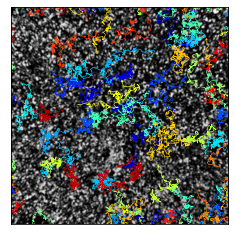

In [34]:
print("-------------------------------------------")
print("--------    Inferred trajectory Processing    ------------")
data_inferred = DataProcessing(swimmer_list_loc_inferred)   

-------------------------------------------
--------    Ground truth Processing    ------------


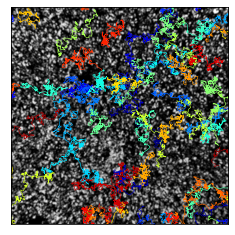

In [35]:
print("-------------------------------------------")
print("--------    Ground truth Processing    ------------")
#----Data processing----#
data = DataProcessing(swimmer_list)

In [36]:
#----Extract the data (biofilm density and gradients) at swimmer position ----#
#----and organize them in dedicated data structure----#
YVx_inf,YVy_inf,YB_inf,YgradBx_inf,YgradBy_inf,YAx_inf,YAy_inf,Yx_inf,Yy_inf,YindexTime_inf,YindexFirst_inf,YindexFirstV_inf,YindexFirstA_inf,truePositionsNb_inf = get_data(Param,data_inferred,bact,gradb_x,gradb_y)


#----Save the data for visualization----#
write_data(Synthetic_data_folder,YVx_inf,YVy_inf,YB_inf,YgradBx_inf,YgradBy_inf,YAx_inf,YAy_inf,Yx_inf,Yy_inf,YindexTime_inf,YindexFirst_inf,YindexFirstV_inf,YindexFirstA_inf,data_inferred,data_basis='SIMU')

# Step 6: Visualize the simulation results

In [37]:
data_d = read_data(Synthetic_data_folder)
data_d['Nta'] = data_d['YindexFirst'][-1]-1 - 2*data_d['data'].swimmer_Nb
data_d_s = read_data(Synthetic_data_folder,data_basis='SIMU')
data_d_s['Nta'] = data_d_s['YindexFirst'][-1]-1 - 2*data_d_s['data'].swimmer_Nb

DATA file:  Synthetic_data/DATA_YVx.dat
DATA file:  Synthetic_data/DATA_YVy.dat
DATA file:  Synthetic_data/DATA_YB.dat
DATA file:  Synthetic_data/DATA_YgradBx.dat
DATA file:  Synthetic_data/DATA_YgradBy.dat
DATA file:  Synthetic_data/DATA_YAx.dat
DATA file:  Synthetic_data/DATA_YAy.dat
DATA file:  Synthetic_data/DATA_Yx.dat
DATA file:  Synthetic_data/DATA_Yy.dat
DATA file:  Synthetic_data/DATA_YindexTime.dat
DATA file:  Synthetic_data/DATA_YindexFirst.dat
DATA file:  Synthetic_data/DATA_YindexFirstV.dat
DATA file:  Synthetic_data/DATA_YindexFirstA.dat
DATA file:  Synthetic_data/DATA_data.dat
DATA file:  Synthetic_data/SIMU_YVx.dat
DATA file:  Synthetic_data/SIMU_YVy.dat
DATA file:  Synthetic_data/SIMU_YB.dat
DATA file:  Synthetic_data/SIMU_YgradBx.dat
DATA file:  Synthetic_data/SIMU_YgradBy.dat
DATA file:  Synthetic_data/SIMU_YAx.dat
DATA file:  Synthetic_data/SIMU_YAy.dat
DATA file:  Synthetic_data/SIMU_Yx.dat
DATA file:  Synthetic_data/SIMU_Yy.dat
DATA file:  Synthetic_data/SIMU_Yind

In [38]:
data_list_a=["YBa","YgradBxa","YgradBya","YVxa","YVya"]
dic_list=[data_d,data_d_s]
for dic in dic_list:
    tmp_t = convert(dic)
    for i_a,a in enumerate(data_list_a):
        dic[a]=tmp_t[i_a]

    
#YBa, YgradBxa, YgradBya, YVxa, YVya = convert(YB, YgradBx, YgradBy, YVx, YVy, YindexFirst[-1]-1, data.swimmer_Nb, YindexFirstA, YindexFirstV, YindexFirst)
#YBsa, YgradBxsa, YgradBysa, YVxsa, YVysa = convert(YBs, YgradBxs, YgradBys, YVxs, YVys, YindexFirsts[-1]-1, datas.swimmer_Nb, YindexFirstAs, YindexFirstVs, YindexFirsts)

In [39]:
print(np.shape(data_d['YAx']),np.shape(data_d_s['YAx']))

(10964,) (10685,)


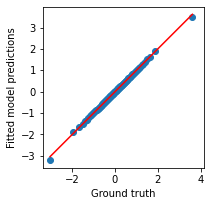

In [40]:
x1 = np.quantile(data_d['YAx']/data_d['data'].Amean,np.linspace(0,1,100))
x2 = np.quantile(data_d_s['YAx']/data_d_s['data'].Amean,np.linspace(0,1,100))
fig,ax=plt.subplots(1,1,figsize=(3,3))
ax.scatter(x1,x2)
ax.plot([min(x1),max(x1)],[min(x1),max(x1)],color="red")
ax.set_xlabel("Ground truth")
ax.set_ylabel("Fitted model predictions")
ax.axis("square")
fig.tight_layout()
fig.savefig("qqplot_x.pdf")
fig.show()

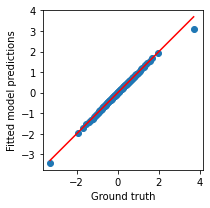

In [41]:
x1 = np.quantile(data_d['YAy']/data_d['data'].Amean,np.linspace(0,1,100))
x2 = np.quantile(data_d_s['YAy']/data_d_s['data'].Amean,np.linspace(0,1,100))
fig,ax=plt.subplots(1,1,figsize=(3,3))
ax.scatter(x1,x2)
ax.plot([min(x1),max(x1)],[min(x1),max(x1)],color="red")
ax.set_xlabel("Ground truth")
ax.set_ylabel("Fitted model predictions")
ax.axis("square")
fig.tight_layout()
fig.savefig("qqplot_y.pdf")
fig.show()

**Legend: Qqplot of ﬁtted model output vs ground truth**. After inference, the ﬁtted model is used to re-compute the synthetic dataset. We plot the x (d) and y (e) components of the accelerations in a qqplot: the ﬁtted model output quantiles are plotted against the quantiles of the original dataset (ground truth) with blue dots, together with the 𝑦 = 𝑥 line (red).

In [42]:
Aref = Arefg
Vref = Vrefg
Xref = Vrefg*Vrefg/Arefg
print("REFS (X-V-A): ",Xref,Vref,Aref)
Dref = Vref*Vref/Aref
Depref = Dref

REFS (X-V-A):  0.8171167081563918 7.47 68.29


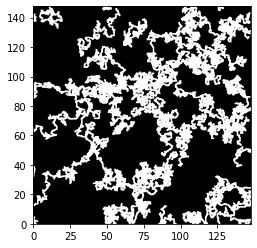

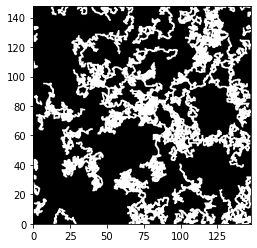

In [43]:
data_d['data'].computeMapOccupancy()
data_d_s['data'].computeMapOccupancy()

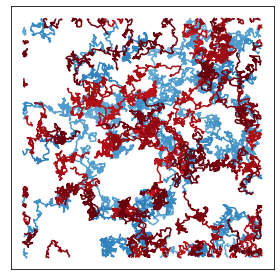

In [44]:
fig, ax = plt.subplots()
Ntot = data_d['data'].swimmer_Nb+data_d_s['data'].swimmer_Nb
plotMap_Obs(0,ax,0,Ntot,
            data_d['Yx'],data_d['Yy'],
            data_d['data'].swimmer_Nb,
            data_d['YindexFirst'],
            data_d['data'].length_x_inf,
            data_d['data'].length_x_sup,
            data_d['data'].length_y_inf,
            data_d['data'].length_y_sup)
plotMap_Obs(1,ax,data_d_s['data'].swimmer_Nb,Ntot,
            data_d_s['Yx'],data_d_s['Yy'],
            data_d_s['data'].swimmer_Nb,
            data_d_s['YindexFirst'],
            data_d_s['data'].length_x_inf,
            data_d_s['data'].length_x_sup,
            data_d_s['data'].length_y_inf,
            data_d_s['data'].length_y_sup)
fig.tight_layout()
fig.savefig("Comparison_trajectory_ground_inference.pdf")
plt.show()

In [45]:
data_visu = ReformateDataForVizualisation(Param, data_d,
                                          Aref,Vref,Xref,
                                          Dref,Depref)
data_visus = ReformateDataForVizualisation(Param, data_d_s,
                                           Aref,Vref,Xref,
                                           Dref,Depref,
                                           species_name='After inferrence')
data_visu_concat={key:pd.concat([data_visu[key],data_visus[key]]) for key in data_visu.keys()}

*****$||A||$
number of trajectories Ground truth 72
mean Ground truth 0.9902549958230354
percentile Ground truth {1: 0.8041251320982427, 5: 0.8884047570719406, 25: 0.957942166193792, 50: 0.9957967222398538, 75: 1.0228187699416174, 95: 1.0634616464450346, 99: 1.1360162457159249}
wideness Ground truth 0.17505688937309405
number of trajectories After inferrence 100
mean After inferrence 1.0002329788401834
percentile After inferrence {1: 0.7378038077727409, 5: 0.8501707504342714, 25: 0.9431432011094254, 50: 0.9970311258335188, 75: 1.0480241189441903, 95: 1.1735355838998265, 99: 1.2812753092289966}
wideness After inferrence 0.3233648334655551
*****$||V||$
number of trajectories Ground truth 72
mean Ground truth 0.9964405036641385
percentile Ground truth {1: 0.8740082380658357, 5: 0.9185515062725891, 25: 0.9608880250169018, 50: 0.9948699540245318, 75: 1.0209453883162052, 95: 1.0746045566592586, 99: 1.1888236777109644}
wideness Ground truth 0.1560530503866695
number of trajectories After infe

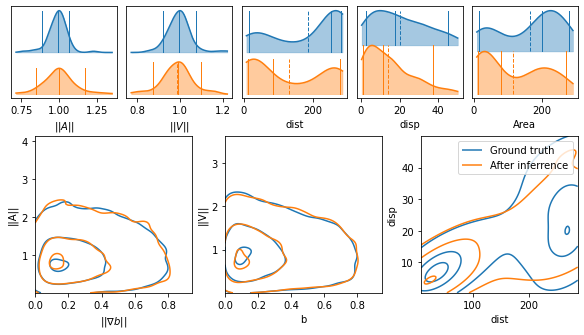

In [46]:
fig =  PlotDescriptors(data_visu_concat,figsize=(8,4.5))
#fig.tight_layout()
fig.savefig('Trajectory_descriptors_ground_inference.pdf')
fig.show()

**Legend: trajectory descriptors after inference, compared to ground truth.** Trajectories are
re-computed replacing the original parameters (ground truth) by the inferred parameters. The trajectory
descriptors introduced in Characterizing bacterial swimming in a bioﬁlm matrix through image descriptors
are computed on the synthetic data (blue curves) and on the data obtained with the inferred parameters
(orange curves).

### Assessing the senstivity of biofilm density in the inference process

The biofilm data are noised with an additive gaussian noise with increasing variance. The noise variance is scaled with the variance observed in the original data. Namely, we set
\begin{equation} \epsilon_{b} \sim \mathcal{N}(0,\sqrt{l}*\sigma_b) \end{equation}
and
\begin{equation} \epsilon_{\nabla b} \sim \mathcal{N}(0,\frac{\sqrt{2l}}{\Delta x}*\sigma_b) \end{equation}
where $\epsilon_b$ and $\epsilon_{\nabla b}$ are respectively the noise applied to the biofilm and the biofilm gradient. Then, inference is repeated for $l \in [0,0.01,0.02,0.03,0.04,0.05]$.

In [47]:
import copy
# biofilm map variance
var = data_d['YB'].var()
noise_levels=[0,0.01,0.02,0.03,0.04,0.05]#,0.06,0.07,0.08,0.09,0.1]

for i_nl, nl in enumerate(noise_levels):
    data_d_noise = copy.deepcopy(data_d)
    noise_b = np.random.normal(loc=0.0,scale = np.sqrt(nl*var),size=data_d_noise['YB'].shape)
    noise_gradbx = np.random.normal(loc=0.0,scale = np.sqrt(2*nl*var/(Param['hx']**2)),size=data_d_noise['YgradBx'].shape)
    noise_gradby = np.random.normal(loc=0.0,scale = np.sqrt(2*nl*var/(Param['hy']**2)),size=data_d_noise['YgradBy'].shape)
    data_d_noise['YB'] = np.clip(data_d_noise['YB']+noise_b,0,1)
    data_d_noise['YgradBx']+=noise_gradbx
    data_d_noise['YgradBy']+=noise_gradby
    
    #---- Create output folder ----#
    Stan_output_folder='InferenceOutputFolder_'+str(100*nl)
    Path(Stan_output_folder).mkdir(exist_ok=True)
    INFERENCE=True
    if INFERENCE:
        #---- Data renormalization ----#
        YVx_renormalized = data_d_noise['YVx']/Param['Vref']
        YVy_renormalized = data_d_noise['YVy']/Param['Vref']
        YAx_renormalized = data_d_noise['YAx']/Param['Aref']
        YAy_renormalized = data_d_noise['YAy']/Param['Aref']

        #---- Bayesian inference. Some warnings pop up during the warmup. This is a normal feature ----#
        fit, df = stanSwimmingA(Param['Xref'], Param['Vref'], Param['Aref'], 
                                data_d_noise['YindexFirst'][-1]-1,
                                Param['Nt'], Param['Ncycle']+1, 
                                data_d_noise['data'].swimmer_Nb, 
                                Param['m'], Param['n'], 0, 0, Param['hx'], 
                                Param['hy'], Param['dt'],
                                YVx_renormalized, YVy_renormalized, 
                                data_d_noise['YB'], 
                                data_d_noise['YgradBx'], 
                                data_d_noise['YgradBy'], 
                                YAx_renormalized, YAy_renormalized, 
                                data_d_noise['YindexTime'], 
                                data_d_noise['YindexFirstA'], 
                                data_d_noise['YindexFirstV'], 
                                data_d_noise['YindexFirst'],
                                output_folder= Stan_output_folder)



    
    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a969e1ddb79d3b58310e71ff69e0ef8 NOW.


Compiling
End compiling
Starting inference
Inference for Stan model: anon_model_1a969e1ddb79d3b58310e71ff69e0ef8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma0   0.59  4.3e-5 2.9e-3   0.59   0.59   0.59    0.6    0.6   4770    1.0
v0       0.65  1.6e-4 9.4e-3   0.63   0.64   0.65   0.66   0.67   3484    1.0
v1       0.14  3.7e-4   0.02   0.09   0.12   0.14   0.15   0.18   3407    1.0
gamma    1.08  1.9e-4   0.01   1.06   1.07   1.08   1.09    1.1   3481    1.0
beta     0.16  8.0e-5 5.9e-3   0.14   0.15   0.16   0.16   0.17   5352    1.0
lp__   469.52    0.04   1.63 465.57 468.71 469.83 470.73 471.66   1667    1.0

Samples were drawn using NUTS at Tue May 10 00:43:18 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a969e1ddb79d3b58310e71ff69e0ef8 NOW.


Compiling
End compiling
Starting inference
Inference for Stan model: anon_model_1a969e1ddb79d3b58310e71ff69e0ef8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma0    0.6  4.3e-5 2.9e-3   0.59   0.59    0.6    0.6    0.6   4384    1.0
v0       0.65  1.7e-4 9.6e-3   0.63   0.64   0.65   0.65   0.67   3023    1.0
v1       0.14  4.0e-4   0.02    0.1   0.12   0.14   0.15   0.18   2928    1.0
gamma    1.08  2.0e-4   0.01   1.06   1.07   1.08   1.09    1.1   3019    1.0
beta     0.13  8.1e-5 5.7e-3   0.12   0.13   0.13   0.13   0.14   4924    1.0
lp__   362.29    0.04    1.6 358.44 361.44 362.62 363.48 364.39   1774    1.0

Samples were drawn using NUTS at Tue May 10 00:50:21 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a969e1ddb79d3b58310e71ff69e0ef8 NOW.


Compiling
End compiling
Starting inference
Inference for Stan model: anon_model_1a969e1ddb79d3b58310e71ff69e0ef8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma0    0.6  3.8e-5 2.9e-3   0.59    0.6    0.6    0.6    0.6   5729    1.0
v0       0.64  1.8e-4 9.5e-3   0.62   0.64   0.64   0.65   0.66   2865    1.0
v1       0.15  3.7e-4   0.02    0.1   0.13   0.15   0.16   0.19   3210    1.0
gamma    1.08  2.0e-4   0.01   1.06   1.07   1.08   1.09    1.1   3122    1.0
beta     0.12  8.1e-5 5.7e-3   0.11   0.12   0.12   0.13   0.13   5020    1.0
lp__   323.91    0.04   1.54 320.14 323.11 324.21 325.03 325.99   1735    1.0

Samples were drawn using NUTS at Tue May 10 00:57:00 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a969e1ddb79d3b58310e71ff69e0ef8 NOW.


Compiling
End compiling
Starting inference
Inference for Stan model: anon_model_1a969e1ddb79d3b58310e71ff69e0ef8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma0    0.6  3.9e-5 2.8e-3   0.59    0.6    0.6    0.6    0.6   5039    1.0
v0       0.64  1.7e-4 9.7e-3   0.62   0.64   0.64   0.65   0.66   3227    1.0
v1       0.15  4.0e-4   0.02   0.11   0.13   0.15   0.16   0.19   2783    1.0
gamma    1.08  2.0e-4   0.01   1.06   1.07   1.08   1.09    1.1   3260    1.0
beta     0.11  8.4e-5 5.8e-3    0.1   0.11   0.11   0.12   0.12   4788    1.0
lp__    290.4    0.04    1.6 286.54 289.55 290.74 291.56 292.51   1779    1.0

Samples were drawn using NUTS at Tue May 10 01:03:23 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a969e1ddb79d3b58310e71ff69e0ef8 NOW.


Compiling
End compiling
Starting inference
Inference for Stan model: anon_model_1a969e1ddb79d3b58310e71ff69e0ef8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma0    0.6  4.2e-5 2.9e-3   0.59    0.6    0.6    0.6    0.6   4912    1.0
v0       0.64  1.8e-4 9.9e-3   0.62   0.64   0.64   0.65   0.66   3032    1.0
v1       0.15  4.1e-4   0.02   0.11   0.13   0.15   0.16   0.19   2714    1.0
gamma    1.08  2.1e-4   0.01   1.06   1.07   1.08   1.09    1.1   2956    1.0
beta     0.11  8.3e-5 5.7e-3    0.1    0.1   0.11   0.11   0.12   4743    1.0
lp__   272.96    0.04   1.59 269.11 272.07 273.27 274.14 275.12   1785    1.0

Samples were drawn using NUTS at Tue May 10 01:10:42 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a969e1ddb79d3b58310e71ff69e0ef8 NOW.


Compiling
End compiling
Starting inference
Inference for Stan model: anon_model_1a969e1ddb79d3b58310e71ff69e0ef8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma0    0.6  4.0e-5 2.8e-3   0.59    0.6    0.6    0.6   0.61   4919    1.0
v0       0.64  1.7e-4 9.5e-3   0.62   0.63   0.64   0.65   0.66   3232    1.0
v1       0.16  3.9e-4   0.02   0.11   0.14   0.16   0.17    0.2   3133    1.0
gamma    1.08  1.9e-4   0.01   1.06   1.07   1.08   1.09    1.1   3517    1.0
beta      0.1  8.4e-5 5.7e-3   0.09    0.1    0.1   0.11   0.11   4595    1.0
lp__   247.25    0.04    1.6 243.28 246.44 247.57  248.4 249.33   1882    1.0

Samples were drawn using NUTS at Tue May 10 01:17:27 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [48]:
dimensions_l=['gamma','v0','v1','beta','sigma']
ground_truth={}
ground_truth['v0']=Param['swimmer_v0_in_biofilm']/Param['Vref']
ground_truth['v1']=Param['swimmer_v1_in_matrix']/Param['Vref']
ground_truth['gamma']=Param['swimmer_gamma']*Param['Vref']/Param['Aref']
ground_truth['beta']=Param['swimmer_beta']/Param['Aref'] 
ground_truth['sigma']=Param['swimmer_eps']/Param['Aref']
results={d:np.zeros((len(noise_levels),)) for d in dimensions_l}
for i_nl, nl in enumerate(noise_levels):
    Stan_output_folder='InferenceOutputFolder_'+str(100*nl)
    dict = read_stan_file(Stan_output_folder+'/STAN_Abis_fit.dat')

    fit = dict['fit']
    infered={}
    infered["gamma"] = fit['gamma']
    infered["v0"] = fit['v0']
    infered["v1"] = fit['v1']
    infered["beta"] = fit['beta']
    infered["sigma"] = fit['sigma0'] #'0'    
    for k in results.keys():
        results[k][i_nl] = np.abs(infered[k].mean()-ground_truth[k])/np.abs(ground_truth[k])

STAN file:  InferenceOutputFolder_0/STAN_Abis_fit.dat
STAN file:  InferenceOutputFolder_1.0/STAN_Abis_fit.dat
STAN file:  InferenceOutputFolder_2.0/STAN_Abis_fit.dat
STAN file:  InferenceOutputFolder_3.0/STAN_Abis_fit.dat
STAN file:  InferenceOutputFolder_4.0/STAN_Abis_fit.dat
STAN file:  InferenceOutputFolder_5.0/STAN_Abis_fit.dat


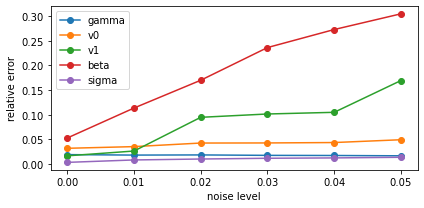

In [49]:
fig,axs=plt.subplots(1,1,figsize=(6,3))
for i_nl, nl in enumerate(dimensions_l):
    i=i_nl%3
    j=i_nl//3    
    axs.plot(noise_levels,results[nl],marker='o',label=nl,c='C'+str(i_nl))
axs.legend()
axs.set_xlabel('noise level')
axs.set_ylabel('relative error')
fig.tight_layout()
fig.savefig('impact_biofilm_noise_inference.pdf')

**Legend: Impact of noise level on parameter inference.** We plot the relative error of
the estimate of the different equation parameters for increasing noise applied on the bioﬁlm density
and the bioﬁlm density gradients input data.